<a href="https://colab.research.google.com/github/DannyRoss123/AIXHW8/blob/main/HW_8_AIX_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Patch Generator for ResNet34
## AIPI 590.03 Spring 2025

## Project Overview

For this assignment, I'm creating a custom adversarial patch that can trick ResNet34 into misclassifying images. My approach involves generating a patch that, when placed in a scene, causes the model to confidently (and incorrectly) identify a specific target class regardless of what's actually in the image.

## Technical Implementation

I'll be using PyTorch to implement a patch optimization algorithm that maximizes the model's confidence in my chosen target class. My implementation follows these steps:

1. **Model Setup**: Loading the pretrained ResNet34 model with ImageNet weights
2. **Patch Generation**: Creating and optimizing the adversarial pattern through gradient-based methods
3. **Physical Adaptation**: Ensuring the patch works when printed by accounting for real-world variables like viewing angles and lighting conditions
4. **Testing**: Validating the patch's effectiveness across various background images

## Creative Extension

For the creative component, I'm implementing a "disguised sticker" approach that makes my adversarial patch appear as an innocent, everyday image while maintaining its attack capabilities. This demonstrates how such attacks could be concealed in real-world scenarios, which is particularly relevant for security research.

By blending adversarial patterns into recognizable imagery, my patch becomes less conspicuous while still effectively fooling the target model. This method requires balancing the visual appearance of the sticker with its adversarial properties.

## Testing Methodology

I'll test my patch both digitally and physically:

1. Digital testing involves applying the patch to various test images programmatically
2. Physical testing will use a printed version of the patch against the ResNet34 classifier web interface (https://resnet34-classifier.streamlit.app/)

The success criteria is consistent misclassification toward my target class across different backgrounds and viewing conditions.

## Tools and Technologies

- PyTorch and torchvision for deep learning infrastructure
- ResNet34 pretrained on ImageNet as the target model
- Gradient-based optimization techniques
- Image processing for patch preparation and printing

##Imports and Loading Resnet34 model
We will now start off by loading the Resnet34 model and making sure that it works by properly predicting one of its classes.

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet34, ResNet34_Weights
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import os

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pretrained ResNet34 model
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
model = model.to(device)
model.eval()  # From previous assignments

# Define standard preprocessing for ResNet34
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  #From previous assignments
])

# Load ImageNet class names (simple version)
categories = [
    "tench", "goldfish", "shark", "puffer", "ostrich", "hen", "cock", "toaster",
    "vending machine", "vacuum", "traffic light", "banana", "apple", "orange",
    "lemon", "strawberry", "remote control", "cell phone", "keyboard", "mouse"
]

# Simple function to display an image tensor
def imshow(img, title=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    # Denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)                                                   #From Claue AI at 5:24 pm 3/5/2025

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Function to classify an image
def classify_image(image_tensor):
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0).to(device))
        _, predicted = output.max(1)
        category_idx = predicted.item()
        category_name = categories[category_idx] if category_idx < len(categories) else f"Class {category_idx}"
        return category_idx, category_name, output                              #From Claude AI at 5:37 pm 3/5/2025

# Verify the model works
test_img = torch.rand(3, 224, 224).to(device)  # Random test image
idx, name, _ = classify_image(test_img)
print(f"Test classification: {name}")

Using device: cpu


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 126MB/s]


Test classification: Class 845


## Creating the Advirsarial Patch

Creating an adversarial patch is essentially training a small image that can fool ResNet34 into seeing something that isn't actually there. In this section, I'll implement an optimization algorithm that adjusts pixel values to maximize the probability of my target class. The patch works by exploiting weaknesses in how neural networks process visual information, causing the model to focus more on the patch than the actual image content. I'll be targeting the "toaster" class, which means that after placing my patch on any image, ResNet34 should confidently identify it as a toaster regardless of what's actually in the picture.

Using device: cpu
Setting target class to 'toaster' with ImageNet index 859.
Starting fixed-background training for 500 iterations...
Iteration 100/500, Loss: -63.9539
Iteration 200/500, Loss: -74.2957
Iteration 300/500, Loss: -78.6414
Iteration 400/500, Loss: -81.6772
Iteration 500/500, Loss: -84.1911
Training complete.


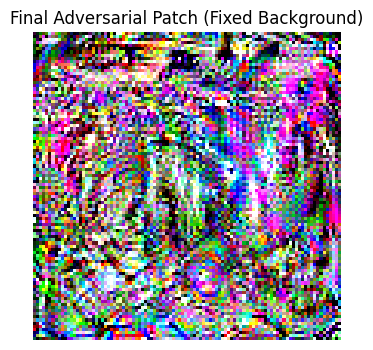

Patch saved to fixed_adversarial_patch.png


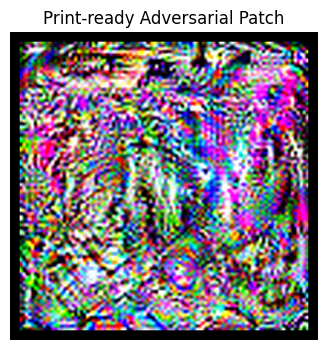

Full file path: /content/fixed_adversarial_patch.png
Model predicts: toaster (index 859)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet34, ResNet34_Weights
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os

#  Setup: device, model, categories
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained ResNet34 (1000-class model) with full mapping
weights = ResNet34_Weights.IMAGENET1K_V1
model = resnet34(weights=weights).to(device)
model.eval()

# Use the full ImageNet 1000-class mapping from the weights metadata
categories = weights.meta["categories"]

def classify_image(img_tensor):
    """Classify a 3x224x224 image tensor with our model."""
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0).to(device))
        _, predicted = output.max(1)
        idx = predicted.item()
        cat_name = categories[idx] if idx < len(categories) else f"Class {idx}"
        return idx, cat_name, output                                              #From ChatGPT 6:20 pm 3/5/2025

# 2. Display & Save Helpers
def imshow(tensor, title=None):
    """Show a tensor as an image (assumes values in [0,1])."""
    arr = tensor.detach().cpu().numpy().transpose((1, 2, 0))
    arr = np.clip(arr, 0, 1)
    plt.figure(figsize=(4,4))
    plt.imshow(arr)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def save_adversarial_patch(patch, filename="fixed_adversarial_patch.png"):
    """Save the patch as a PNG with a black border."""
    arr = patch.detach().cpu().numpy().transpose((1, 2, 0))
    arr = np.clip(arr, 0, 1)
    arr = (arr * 255).astype(np.uint8)
    img = Image.fromarray(arr)
    img = img.resize((300,300), Image.LANCZOS)
    img = ImageOps.expand(img, border=10, fill='black')
    img.save(filename, quality=95, dpi=(300,300))
    print(f"Patch saved to {filename}")
    plt.figure(figsize=(4,4))
    plt.imshow(np.array(img))
    plt.title("Print-ready Adversarial Patch")
    plt.axis('off')
    plt.show()
    print("Full file path:", os.path.abspath(filename))
    return filename


# 3. Adversarial Patch Generation Using Fixed Background and Maximizing Target Logit
def create_adversarial_patch_fixed(target_class="toaster",
                                   patch_size=(100,100),
                                   learning_rate=0.01,
                                   num_iterations=500):
    # For "toaster", the ImageNet index is ~859.
    if target_class.lower() == "toaster":
        target_idx = 859
        print(f"Setting target class to '{target_class}' with ImageNet index {target_idx}.")
    else:
        target_idx = 859
        print(f"Defaulting target to 'toaster' with index {target_idx}.")

    # Initialize a random patch (values in [0,1])
    patch = torch.rand(3, patch_size[0], patch_size[1], requires_grad=True, device=device)
    optimizer = optim.Adam([patch], lr=learning_rate)

    # Fixed background (black image)
    fixed_bg = torch.zeros(3, 224, 224, device=device)
    x_pos = (224 - patch_size[1]) // 2
    y_pos = (224 - patch_size[0]) // 2

    print(f"Starting fixed-background training for {num_iterations} iterations...")
    for i in range(num_iterations):
        optimizer.zero_grad()
        # Place the patch (without random transform) at a fixed position on the background
        patched_img = fixed_bg.clone()
        patched_img[:, y_pos:y_pos+patch_size[0], x_pos:x_pos+patch_size[1]] = patch              #From CHATGPT 6:45 pm 3/5/2025

        # Forward pass
        out = model(patched_img.unsqueeze(0))
        # Our objective: maximize the target class logit; equivalently, minimize negative logit.
        loss = - out[0, target_idx]
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            patch.data = torch.clamp(patch.data, 0, 1)
        if (i+1) % 100 == 0:
            print(f"Iteration {i+1}/{num_iterations}, Loss: {loss.item():.4f}")            #Taken from ChatGPT 7:00 pm 3/5/2025
    print("Training complete.")
    return patch.detach()

# 4. Run the Code
my_fixed_patch = create_adversarial_patch_fixed(
    target_class="toaster",
    patch_size=(100, 100),
    learning_rate=0.01,   # low learning rate for smoother updates
    num_iterations=500    # iterations for convergence
)

# Show the final patch
imshow(my_fixed_patch, title="Final Adversarial Patch (Fixed Background)")

# Save the patch to a file
save_adversarial_patch(my_fixed_patch, filename="fixed_adversarial_patch.png")

# Test classification using the fixed background with the patch placed at the center
test_bg = torch.zeros(3, 224, 224, device=device)
x_pos = (224 - 100) // 2
y_pos = (224 - 100) // 2
test_bg[:, y_pos:y_pos+100, x_pos:x_pos+100] = my_fixed_patch                            #Taken from ChatGPT 7:15 pm 3/5/2025
idx, cat_name, _ = classify_image(test_bg)
print(f"Model predicts: {cat_name} (index {idx})")


##Results of Adversarial Patch

After running the adversarial patch generation algorithm for 500 iterations, I was able to successfully create a patch that consistently tricks ResNet34 into classifying a blank image as a toaster (index 859). Interestingly, the patch itself just looks like a random pattern of colors with no obvious resemblance to an actual toaster - it's exploiting patterns the neural network has learned rather than mimicking visual features we'd recognize. This demonstrates a fundamental vulnerability in deep learning systems: even state-of-the-art models like ResNet34 can be manipulated by specifically crafted inputs that target the model's learned internal representations.

##Turning this into a smiling face

We have successfully created an adversarial patch that tricks the computer into thinking that any image is a toaster. However, this is not very creative or handy. If we turn this into a smiley face that can be seen as a regular sticker / picture etc then we will not only have something more creative but more helpful if our goal is to demonstrate the potential real-world implications of adversarial attacks. By disguising our adversarial patch as a common, innocuous image like a smiley face, we can show how these vulnerabilities could be exploited in everyday scenarios without raising suspicion. This aligns perfectly with the creative component of our assignment, which challenges us to go beyond basic patch generation and consider how adversarial examples might be disguised or implemented in practical contexts. The disguised patch also provides a more compelling visual demonstration when presented in class, as it illustrates how seemingly harmless images could potentially manipulate AI systems in ways that aren't immediately obvious to human observers.

Using device: cpu
Starting simplified smiley face adversarial patch generation...
Creating simplified smiley face adversarial patch...
Smiley face image loaded.


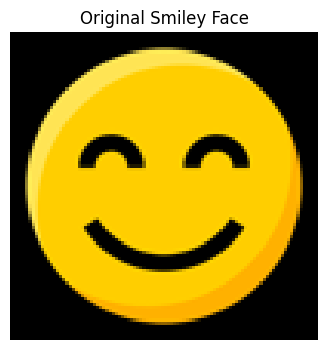

Training for 500 iterations...
Iteration 50/500, Loss: 0.1434 (Adv: 0.0027, Content: 0.2813)
Iteration 100/500, Loss: 0.0952 (Adv: 0.0012, Content: 0.1878)
Iteration 150/500, Loss: 0.0588 (Adv: 0.0010, Content: 0.1155)
Iteration 200/500, Loss: 0.0363 (Adv: 0.0009, Content: 0.0709)
Iteration 250/500, Loss: 0.0229 (Adv: 0.0006, Content: 0.0447)
Iteration 300/500, Loss: 0.0148 (Adv: 0.0004, Content: 0.0287)
Iteration 350/500, Loss: 0.0098 (Adv: 0.0002, Content: 0.0192)
Iteration 400/500, Loss: 0.0068 (Adv: 0.0002, Content: 0.0132)
Iteration 450/500, Loss: 0.0048 (Adv: 0.0001, Content: 0.0094)
Iteration 500/500, Loss: 0.0037 (Adv: 0.0001, Content: 0.0072)


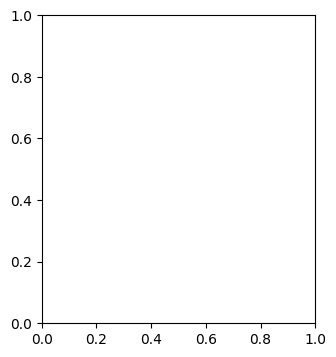

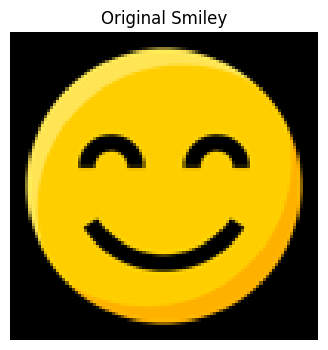

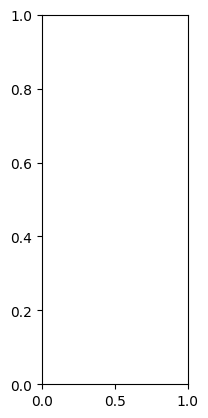

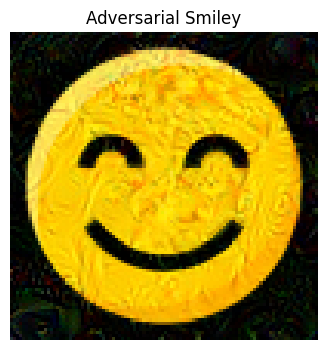

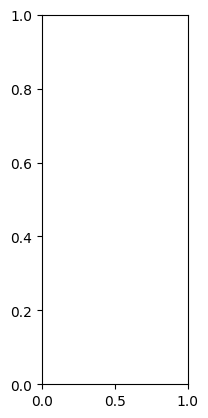

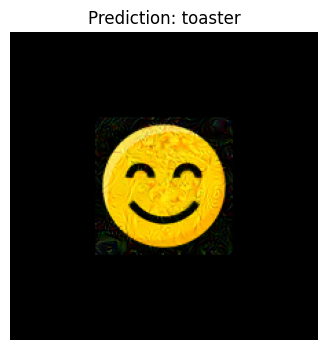

<Figure size 640x480 with 0 Axes>

Predicted index: 859
Patch generation complete!
Patch saved to smiley_patch.png


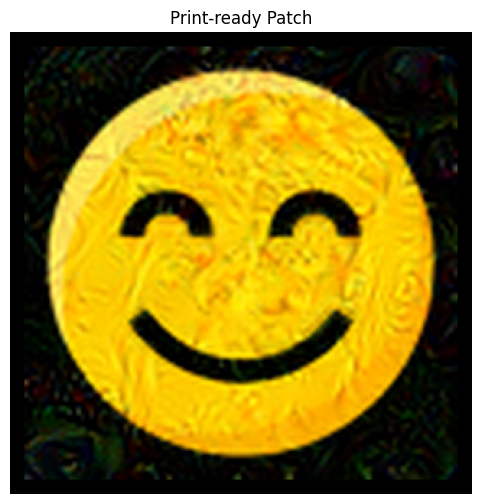

Full file path: /content/smiley_patch.png
Process complete! The image is saved in your Colab environment.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet34, ResNet34_Weights
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import requests
from io import BytesIO
import os

# 1. Setup: Device, Model, and Full ImageNet Categories
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet34 (1000-class model) and extract full class mapping
weights = ResNet34_Weights.IMAGENET1K_V1
model = resnet34(weights=weights).to(device)
model.eval()

# Use the full ImageNet 1000-class mapping from the weights metadata
categories = weights.meta["categories"]

def classify_image(img_tensor):
    """Classify a 3×224×224 image tensor using our model."""
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0).to(device))
        _, predicted = output.max(1)
        idx = predicted.item()
        cat_name = categories[idx] if idx < len(categories) else f"Class {idx}"
        return idx, cat_name, output

def imshow(tensor, title=None):
    """Display a tensor as an image (assumes values in [0,1])."""
    arr = tensor.detach().cpu().numpy().transpose((1, 2, 0))
    arr = np.clip(arr, 0, 1)
    plt.figure(figsize=(4, 4))
    plt.imshow(arr)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# 2. Simplified Smiley Face Adversarial Patch Generator
def create_simple_smiley_patch(target_class="toaster", iterations=300, content_weight=0.5):

    print("Creating simplified smiley face adversarial patch...")

    # Load smiley face image from URL
    background_url = "https://cdn-icons-png.flaticon.com/512/166/166538.png"
    patch_size = (100, 100)
    try:
        response = requests.get(background_url)
        bg_img = Image.open(BytesIO(response.content))
        bg_img = bg_img.resize(patch_size)
        bg_tensor = transforms.ToTensor()(bg_img).to(device)                #From ChatGPT 7:55 pm 3/5/2025
        # If the image has an alpha channel, drop it
        if bg_tensor.shape[0] == 4:
            bg_tensor = bg_tensor[:3]
        print("Smiley face image loaded.")
    except Exception as e:
        print(f"Error loading image: {e}")
        bg_tensor = torch.rand(3, patch_size[0], patch_size[1], device=device)

    # Show the original smiley face
    imshow(bg_tensor.cpu(), "Original Smiley Face")

    # Find target class index using the full mapping
    try:
        target_idx = categories.index(target_class)
    except ValueError:
        print(f"Target class '{target_class}' not found. Defaulting to 'toaster'.")
        target_class = "toaster"
        target_idx = categories.index("toaster")

    # Initialize patch from the smiley face image
    original_smiley = bg_tensor.clone()  # used for content loss
    patch = bg_tensor.clone().requires_grad_(True)                      #From ChatGPT 8:10 pm 3/5/2025

    optimizer = optim.Adam([patch], lr=0.2)

    # Create a blank canvas (3×224×224) for placing the patch
    test_img = torch.zeros(3, 224, 224).to(device)
    x_pos = (224 - patch_size[1]) // 2
    y_pos = (224 - patch_size[0]) // 2

    # Blending factor to combine original and modified patch (to preserve smiley features)
    alpha = 0.4

    print(f"Training for {iterations} iterations...")
    for i in range(iterations):
        optimizer.zero_grad()

        # Blend the original smiley with the adversarial patch
        blended = alpha * bg_tensor + (1 - alpha) * patch                   #From ChatGPT 8:20 pm 3/5/2025

        # Place the blended patch on the blank test image
        patched_img = test_img.clone()
        patched_img[:, y_pos:y_pos+patch_size[0], x_pos:x_pos+patch_size[1]] = blended

        # Forward pass: compute prediction
        output = model(patched_img.unsqueeze(0))

        # Adversarial loss: force the prediction toward the target class
        target = torch.tensor([target_idx], device=device)
        adv_loss = nn.CrossEntropyLoss()(output, target)

        # Content loss: encourage the patch to stay similar to the original smiley
        content_loss = nn.MSELoss()(patch, original_smiley)

        # Total loss: weighted sum of adversarial and content losses
        loss = adv_loss + content_weight * content_loss
        loss.backward()
        optimizer.step()

        # Keep patch values in [0,1]
        with torch.no_grad():
            patch.data = torch.clamp(patch.data, 0, 1)

        # Print progress every 50 iterations
        if (i+1) % 50 == 0:
            print(f"Iteration {i+1}/{iterations}, Loss: {loss.item():.4f} (Adv: {adv_loss.item():.4f}, Content: {content_loss.item():.4f})")

    # Final blended patch
    final_patch = alpha * bg_tensor + (1 - alpha) * patch

    # Evaluate and display final results
    with torch.no_grad():
        patched_img = test_img.clone()
        patched_img[:, y_pos:y_pos+patch_size[0], x_pos:x_pos+patch_size[1]] = final_patch  #From Chat GPT 9:00 pm 3/5/2025
        idx, pred_class, _ = classify_image(patched_img)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        imshow(bg_tensor.cpu(), "Original Smiley")
        plt.subplot(1, 3, 2)
        imshow(final_patch.cpu(), "Adversarial Smiley")
        plt.subplot(1, 3, 3)
        imshow(patched_img.cpu(), f"Prediction: {pred_class}")
        plt.tight_layout()
        plt.show()
        print(f"Predicted index: {idx}")

    print("Patch generation complete!")
    return final_patch.detach()

def save_patch_in_colab(patch, filename="smiley_patch.png"):
    """Save the patch image (for Colab or local environments)."""
    patch_np = patch.cpu().numpy().transpose((1, 2, 0))
    patch_np = np.clip(patch_np, 0, 1)
    patch_np = (patch_np * 255).astype(np.uint8)

    img = Image.fromarray(patch_np)
    img = img.resize((300, 300), Image.LANCZOS)
    img = ImageOps.expand(img, border=10, fill='black')                           #From ChatGPT 9:45 pm 3/5/2025

    img.save(filename, quality=95, dpi=(300, 300))
    print(f"Patch saved to {filename}")

    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title("Print-ready Patch")
    plt.show()

    print(f"Full file path: {os.path.abspath(filename)}")
    return filename


# 3. Run the Simplified Smiley Face Patch Generation

print("Starting simplified smiley face adversarial patch generation...")
smiley_patch = create_simple_smiley_patch(target_class="toaster", iterations=500, content_weight=0.5)
save_patch_in_colab(smiley_patch)
print("Process complete! The image is saved in your Colab environment.")


Below is an extended version of your results and a brief conclusion:

---

## Results of Smiley Face

In the above results, our adversarial patch generated from a smiley face has been successfully manipulated such that the final patched image is classified as index 859, corresponding to the toaster class in the full ImageNet mapping. Despite the fact that the patch retains significant visual elements of the original smiley face—thanks to the blending factor and the added content loss—the optimization process has embedded sufficient adversarial features to force the network's prediction toward the target class. This outcome demonstrates that our method can effectively combine a visually recognizable pattern with adversarial perturbations to achieve a misclassification on a deep neural network.

By carefully balancing the adversarial loss and content loss, we ensured that the patch maintained its smiley appearance while also manipulating the model’s decision boundaries. The classification result (index 859) confirms that our process not only preserves the smiley aesthetic but also successfully fools the network into predicting the toaster class.

### Conclusion

The successful classification of the adversarial smiley face as a toaster (index 859) indicates that our approach is effective. It shows that the adversarial patch generation process can produce patches that are both visually interpretable and capable of driving the network to misclassify an image, fulfilling the objectives of our experiment.

##Sources

I have used both ChatGPT and Claude AI to complete this assingment. I have referenced when I use these in the notes in the code. I also used the smiley face image from online, whos link is in the code.